In [ ]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import pickle
import copy
from scipy import stats
from scipy import stats
from numpy import linalg as LA
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from utils import *
from nn_utils import *

def model_comp_test_assemble(V1,V2,cov1,cov2,U1,U2,N):
    Sigma11 = cov1
    Sigma22 = cov2
    Sigma21 = np.matmul(U2,U1.T)/(N**2)   
    Sigma12 = np.matmul(U1,U2.T)/(N**2)  
    Sigma = Sigma11 + Sigma22 - Sigma21 - Sigma12
    test_stat = np.matmul(np.matmul((V1-V2).T,np.linalg.inv(Sigma)),V1-V2).flatten()
    pvalue = 1 - stats.chi2.cdf(test_stat, V1.shape[0])
    return pvalue

In [ ]:
X_train_split, y_train_split, X_test_all, y_test, X_test = get_real('data/house.csv')
N = X_train_split[0].shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (1,11,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [ ]:
def rf_boost_result():
    open_file = open("data/real_data_RF_boost_B_1000.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()

    mse_all = []
    Sigma1_ls = []
    Sigma2_ls = []
    V1_ls = []
    V2_ls = []
    mse1_ls = []
    mse2_ls = []
    for i in range(len(result_rf)):
        result_ls = result_rf[i]
        cov_ij1,cov_ijc1, cov_c1, U_ij1, V1, _ = result_ls[0][0]
        cov_ij2,cov_ijc2, cov_c2, U_ij2, V2, _ = result_ls[0][1]
        pred1 = result_ls[0][2].flatten()
        pred2 = result_ls[0][3].flatten()
        Sigma11 = cov_c1
        Sigma22 = cov_c2
        Sigma21 = np.matmul(U_ij1,U_ij2.T)/(N**2)   
        Sigma12 = np.matmul(U_ij2,U_ij1.T)/(N**2)  
        Sigma2 = Sigma11 + Sigma22 + Sigma21 + Sigma12
        Sigma1_ls.append(cov_c1)
        Sigma2_ls.append(Sigma2)
        V1_ls.append(V1)
        V2_ls.append(V1+V2)
        mse1 = np.mean((pred1 - y_test)**2)
        mse2 = np.mean((pred1+pred2 - y_test)**2)
        mse1_ls.append(mse1)
        mse2_ls.append(mse2)

    mse1 = np.mean(mse1_ls)
    mse2 = np.mean(mse2_ls)

    V1_arr = np.concatenate(V1_ls,1)
    V1_mean = np.mean(V1_arr,1)
    V2_arr = np.concatenate(V2_ls,1)
    V2_mean = np.mean(V2_arr,1)

    pvalue_exp1 = np.zeros(n_test)
    pvalue_exp2 = np.zeros(n_test)
    for k in range(n_test):
        pvalue1_ls = []
        pvalue2_ls = []
        for i in range(len(result_rf)):
            Sigma1_k = np.max([Sigma1_ls[i][k,k],0])
            Sigma2_k = np.max([Sigma2_ls[i][k,k],0])
            pvalue1 = 0
            pvalue2 = 0
            train_list = np.arange(len(result_rf)).tolist()
            train_list.pop(i)
            for j in train_list:
                if (V1_ls[i][k,0] - np.sqrt(2)*1.96*np.sqrt(Sigma1_k) < V1_ls[j][k,0]) and (V1_ls[i][k,0] + np.sqrt(2)*1.96*np.sqrt(Sigma1_k) > V1_ls[j][k,0]):
                    pvalue1 = pvalue1 + 1/len(train_list)
                if (V2_ls[i][k,0] - np.sqrt(2)*1.96*np.sqrt(Sigma2_k) < V2_ls[j][k,0]) and (V2_ls[i][k,0] + np.sqrt(2)*1.96*np.sqrt(Sigma2_k) > V2_ls[j][k,0]):
                    pvalue2 = pvalue2 + 1/len(train_list)
            pvalue1_ls.append(pvalue1)
            pvalue2_ls.append(pvalue2)
        pvalue_exp1[k] = np.mean(pvalue1_ls)
        pvalue_exp2[k] = np.mean(pvalue2_ls)
    return pvalue_exp1,pvalue_exp2, mse1, mse2

In [ ]:
def lm_boost_result():
    open_file = open("data/real_data_LM_boost_B_1000.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()

    mse_all = []
    Sigma1_ls = []
    Sigma2_ls = []
    V1_ls = []
    V2_ls = []
    mse1_ls = []
    mse2_ls = []
    for i in range(len(result_rf)):
        result_ls = result_rf[i]
        Sigma1, U, _, V1 = result_ls[0][0]
        cov_ij,cov_ijc, cov_c, U_ij, V2,_ = result_ls[0][1]
        pred1 = result_ls[0][2].flatten()
        pred2 = result_ls[0][3].flatten()
        Sigma11 = Sigma1
        Sigma22 = cov_c
        Sigma21 = np.matmul(U_ij,U.T)/(N**2)   
        Sigma12 = np.matmul(U,U_ij.T)/(N**2)  
        Sigma2 = Sigma11 + Sigma22 + Sigma21 + Sigma12
        Sigma1_ls.append(Sigma1)
        Sigma2_ls.append(Sigma2)
        V1_ls.append(V1)
        V2_ls.append(V1+V2)
        mse1 = np.mean((pred1 - y_test)**2)
        mse2 = np.mean((pred1+pred2 - y_test)**2)
        mse1_ls.append(mse1)
        mse2_ls.append(mse2)

    mse1 = np.mean(mse1_ls)
    mse2 = np.mean(mse2_ls)

    V1_arr = np.concatenate(V1_ls,1)
    V1_mean = np.mean(V1_arr,1)
    V2_arr = np.concatenate(V2_ls,1)
    V2_mean = np.mean(V2_arr,1)

    pvalue_exp1 = np.zeros(n_test)
    pvalue_exp2 = np.zeros(n_test)
    for k in range(n_test):
        pvalue1_ls = []
        pvalue2_ls = []
        for i in range(len(result_rf)):
            Sigma1_k = np.max([Sigma1_ls[i][k,k],0])
            Sigma2_k = np.max([Sigma2_ls[i][k,k],0])
            pvalue1 = 0
            pvalue2 = 0
            train_list = np.arange(len(result_rf)).tolist()
            train_list.pop(i)
            for j in train_list:
                if (V1_ls[i][k,0] - np.sqrt(2)*1.96*np.sqrt(Sigma1_k) < V1_ls[j][k,0]) and (V1_ls[i][k,0] + np.sqrt(2)*1.96*np.sqrt(Sigma1_k) > V1_ls[j][k,0]):
                    pvalue1 = pvalue1 + 1/len(train_list)
                if (V2_ls[i][k,0] - np.sqrt(2)*1.96*np.sqrt(Sigma2_k) < V2_ls[j][k,0]) and (V2_ls[i][k,0] + np.sqrt(2)*1.96*np.sqrt(Sigma2_k) > V2_ls[j][k,0]):
                    pvalue2 = pvalue2 + 1/len(train_list)
            pvalue1_ls.append(pvalue1)
            pvalue2_ls.append(pvalue2)
        pvalue_exp1[k] = np.mean(pvalue1_ls)
        pvalue_exp2[k] = np.mean(pvalue2_ls)
    return pvalue_exp1,pvalue_exp2, mse1, mse2

In [ ]:
def rf_modif_result():
    open_file = open("data/real_data_RF_B_1000.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()

    mse_all = []
    Sigma1_ls = []
    Sigma2_ls = []
    V1_ls = []
    V2_ls = []
    mse1_ls = []
    mse2_ls = []
    for i in range(len(result_rf)):
        result_ls = result_rf[i]
        cov_ij,cov_ijc, cov_c, cov_bias, U_ij,U_bias, pred, bias, bias_all  = result_ls[0][0]
        pred1 = result_ls[0][1]
        Sigma11 = cov_c
        Sigma22 = cov_bias
        Sigma21 = np.matmul(U_ij,U_bias.T)/(N**2)   
        Sigma12 = np.matmul(U_bias,U_ij.T)/(N**2)  
        Sigma2 = Sigma11 + Sigma22 + Sigma21 + Sigma12
        Sigma1_ls.append(cov_c)
        Sigma2_ls.append(Sigma2)
        V1_ls.append(pred)
        V2_ls.append(pred+bias)

        mse1 = np.mean((pred1 - y_test)**2)
        mse1_ls.append(mse1)
        mse2 = np.mean((pred1+bias_all.flatten()-y_test)**2)
        mse2_ls.append(mse2)

    mse1 = np.mean(mse1_ls)
    mse2 = np.mean(mse2_ls)

    V1_arr = np.concatenate(V1_ls,1)
    V1_mean = np.mean(V1_arr,1)
    V2_arr = np.concatenate(V2_ls,1)
    V2_mean = np.mean(V2_arr,1)

    pvalue_exp1 = np.zeros(n_test)
    pvalue_exp2 = np.zeros(n_test)
    for k in range(n_test):
        pvalue1_ls = []
        pvalue2_ls = []
        for i in range(len(result_rf)):
            Sigma1_k = np.max([Sigma1_ls[i][k,k],0])
            Sigma2_k = np.max([Sigma2_ls[i][k,k],0])
            pvalue1 = 0
            pvalue2 = 0
            train_list = np.arange(len(result_rf)).tolist()
            train_list.pop(i)
            for j in train_list:
                if (V1_ls[i][k,0] - np.sqrt(2)*1.96*np.sqrt(Sigma1_k) < V1_ls[j][k,0]) and (V1_ls[i][k,0] + np.sqrt(2)*1.96*np.sqrt(Sigma1_k) > V1_ls[j][k,0]):
                    pvalue1 = pvalue1 + 1/len(train_list)
                if (V2_ls[i][k,0] - np.sqrt(2)*1.96*np.sqrt(Sigma2_k) < V2_ls[j][k,0]) and (V2_ls[i][k,0] + np.sqrt(2)*1.96*np.sqrt(Sigma2_k) > V2_ls[j][k,0]):
                    pvalue2 = pvalue2 + 1/len(train_list)
            pvalue1_ls.append(pvalue1)
            pvalue2_ls.append(pvalue2)
        pvalue_exp1[k] = np.mean(pvalue1_ls)
        pvalue_exp2[k] = np.mean(pvalue2_ls)
    return pvalue_exp1,pvalue_exp2, mse1, mse2

In [ ]:
def xgboost_result():
    open_file = open("data/real_data_XGB_B_1000.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()

    Sigma1_ls = []
    V1_ls = []
    mse1_ls = []
    for i in range(len(result_rf)):
        result_ls = result_rf[i]
        cov_ij,cov_ijc, cov_c, U_ij, V = result_ls[0]
        pred1 = result_ls[1].flatten()

        Sigma1_ls.append(cov_c)
        V1_ls.append(V)
        mse1 = np.mean((pred1 - y_test)**2)
        mse1_ls.append(mse1)

    mse1 = np.mean(mse1_ls)

    V1_arr = np.concatenate(V1_ls,1)
    V1_mean = np.mean(V1_arr,1)

    pvalue_exp1 = np.zeros(n_test)
    for k in range(n_test):
        pvalue1_ls = []
        for i in range(len(result_rf)):
            Sigma1_k = np.max([Sigma1_ls[i][k,k],0])
            pvalue1 = 0
            train_list = np.arange(len(result_rf)).tolist()
            train_list.pop(i)
            for j in train_list:
                if (V1_ls[i][k,0] - np.sqrt(2)*1.96*np.sqrt(Sigma1_k) < V1_ls[j][k,0]) and (V1_ls[i][k,0] + np.sqrt(2)*1.96*np.sqrt(Sigma1_k) > V1_ls[j][k,0]):
                    pvalue1 = pvalue1 + 1/len(train_list)
            pvalue1_ls.append(pvalue1)
        pvalue_exp1[k] = np.mean(pvalue1_ls)
    return pvalue_exp1, mse1

Text(0.5, 1.0, ' ')

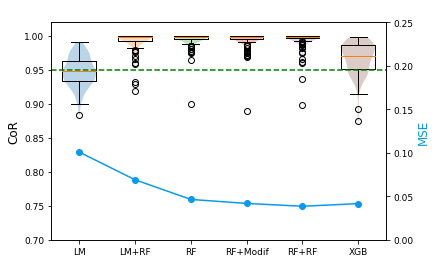

In [ ]:
f, ax = plt.subplots()
ticks = ['LM','LM+RF','RF','RF+Modif','RF+RF','XGB']
n_test = 100

ax1 = ax
pvalue_lm,pvalue_lm_boost, mse_lm, mse_lm_boost = lm_boost_result()
pvalue_rf,pvalue_rf_boost, mse_rf, mse_rf_boost = rf_boost_result()
pvalue_rf0,pvalue_rf_modif, mse_rf0, mse_rf_modif = rf_modif_result()
pvalue_xgb, mse_xgb = xgboost_result()
ax1.boxplot(pvalue_lm,positions=[1],widths=0.6)
ax1.boxplot(pvalue_lm_boost,positions=[2],widths=0.6)
ax1.boxplot(pvalue_rf,positions=[3],widths=0.6)
ax1.boxplot(pvalue_rf_modif,positions=[4],widths=0.6)
ax1.boxplot(pvalue_rf_boost,positions=[5],widths=0.6)
ax1.boxplot(pvalue_xgb,positions=[6],widths=0.6)
ax1.violinplot(pvalue_lm,positions=[1],widths=0.6,showextrema=False)
ax1.violinplot(pvalue_lm_boost,positions=[2],widths=0.6,showextrema=False)
ax1.violinplot(pvalue_rf,positions=[3],widths=0.6,showextrema=False)
ax1.violinplot(pvalue_rf_modif,positions=[4],widths=0.6,showextrema=False)
ax1.violinplot(pvalue_rf_boost,positions=[5],widths=0.6,showextrema=False)
ax1.violinplot(pvalue_xgb,positions=[6],widths=0.6,showextrema=False)

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xticks(np.arange(1, 7, 1))
ax1.set_xticklabels(ticks,fontsize= 9)
ax1.set_ylim([0.7,1.02])
ax1.set_ylabel('CoR', fontsize=12)
ax1.set_title(" ", fontsize=12)
ax1.axhline(y=0.95, color='green', linestyle='--')

ax2=ax1.twinx()
ax2.plot(np.arange(1, 7, 1),[mse_lm,mse_lm_boost,mse_rf,mse_rf_modif,mse_rf_boost,mse_xgb],'-o',color="#069AF3")
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.set_xticks(np.arange(1, 7, 1))
ax2.set_xticklabels(ticks,fontsize= 9)
ax2.set_ylim([0,0.25])
ax2.set_ylabel('MSE',color="#069AF3", fontsize=12)
ax2.set_title(" ", fontsize=12)

In [ ]:
def generate_result_all(B):
    s_frac = 0.2
    n_estimators = B

    open_file = open("data/real_data_LM"+".pkl", "rb")
    result_glm = pickle.load(open_file)
    open_file.close()

    open_file = open("data/real_data_LM_boost_B_1000_new.pkl", "rb")
    result_lm_boost = pickle.load(open_file)
    open_file.close()

    open_file = open("data/real_data_RF_B_1000.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()

    open_file = open("data/real_data_RF_boost_B_1000_new.pkl", "rb")
    result_rf_boost = pickle.load(open_file)
    open_file.close()

    open_file = open("data/real_data_XGB_B_1000.pkl", "rb")
    result_xgboost = pickle.load(open_file)
    open_file.close()

    result_all = []
    for i in range(len(result_rf)):
        result = []

        # LM
        result.append(result_glm[i][0])

        # boost LM
        for i in range(len(result_lm_boost)):
            result_ls = result_lm_boost[i]
            Sigma1, U, _, V1 = result_ls[0][0]
            cov_ij,cov_ijc, cov_c, U_ij, V2,_ = result_ls[0][1]
            Sigma11 = Sigma1
            Sigma22 = cov_c
            Sigma21 = np.matmul(U_ij,U.T)/(N**2)   
            Sigma12 = np.matmul(U,U_ij.T)/(N**2)  
            Sigma2 = Sigma11 + Sigma22 + Sigma21 + Sigma12
        result.append([Sigma2,U + U_ij,V1 + V2])

        # boost RF
        for i in range(len(result_rf_boost)):
            result_ls = result_rf_boost[i]
            cov_ij1,cov_ijc1, cov_c1, U_ij1, V1, _ = result_ls[0][0]
            cov_ij2,cov_ijc2, cov_c2, U_ij2, V2, _ = result_ls[0][1]
            Sigma11 = cov_c1
            Sigma22 = cov_c2
            Sigma21 = np.matmul(U_ij1,U_ij2.T)/(N**2)   
            Sigma12 = np.matmul(U_ij2,U_ij1.T)/(N**2)  
            Sigma2 = Sigma11 + Sigma22 + Sigma21 + Sigma12
        result.append([Sigma2,U_ij1 + U_ij2,V1 + V2])

        # RF
        result.append([result_rf[i][0][0][2],result_rf[i][0][0][4],result_rf[i][0][0][6]])

        # modif
        cov_ij,cov_ijc, cov_c, cov_bias, U_ij,U_bias, pred, bias, bias_all  = result_rf[i][0][0]
        Sigma11 = cov_c
        Sigma22 = cov_bias
        Sigma21 = np.matmul(U_ij,U_bias.T)/(N**2)   
        Sigma12 = np.matmul(U_bias,U_ij.T)/(N**2)  
        Sigma2 = Sigma11 + Sigma22 + Sigma21 + Sigma12
        result.append([Sigma2,U_ij+U_bias,pred + bias])

        # XGBoost
        result.append([result_xgboost[i][0][2],result_xgboost[i][0][3],result_xgboost[i][0][4]])

        result_all.append(result)
    return result_all

# comparison of RF and glm
def generate_plot_single_comp(result_all,ax1,node):
    param_dict = ['LM','LM+RF','RF+RF','RF','RF+Modif','XGB']
    power_mat = np.zeros([len(param_dict),len(param_dict)])
    for i in range(1):
        result_ls = result_all[i]
        for j0 in range(len(result_ls)-1):
            j = j0+1
            for k in range(j):
                cov1, U1, V1 = result_ls[j]
                cov2, U2, V2 = result_ls[k]
                Sigma11 = cov1[node,node]
                Sigma22 = cov2[node,node]
                Sigma21 = np.sum(U2[node]*U1[node])/(N**2)   
                Sigma12 = np.sum(U1[node]*U2[node])/(N**2)  
                Sigma = Sigma11 + Sigma22 - Sigma21 - Sigma12
                test_stat = (V1[node]-V2[node])**2/Sigma
                pvalue = 1 - stats.chi2.cdf(test_stat, 1)
                if pvalue<0.05:
                    power_mat[len(param_dict)-k-1,j] += 1-pvalue

    ax1.set_title('Comparisons Heatmap')
    x_axis_labels = param_dict
    y_axis_labels = x_axis_labels[::-1][1:]
    sns.set(rc = {'figure.figsize':(6,4)})
    sns.heatmap(power_mat[1:,:], linewidth=0.5, cmap="YlGnBu",vmin = 0, vmax=1, xticklabels=x_axis_labels, yticklabels=y_axis_labels,ax=ax1)
    # print(power_mat[1:,:])

Text(0, 0.5, 'Prediction')

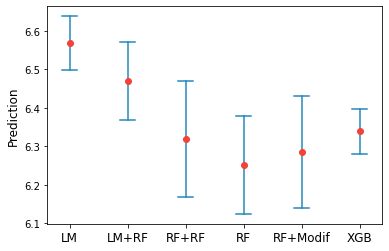

In [ ]:
result_all = generate_result_all(1000)
node = 22

V_all = []
ci_all = []
pvalue_all = []
for j in range(6):
    diff_ls = []
    ci_ls = []
    i = 0
    result_ls = result_all[i]
    cov, U, V = result_ls[j]
    V = V[node]
    Sigma = cov[node,node]
    ci = 1.96*np.sqrt(np.max([Sigma,0]))
    test_stat = (V)**2/Sigma
    pvalue = 1 - stats.chi2.cdf(test_stat, 1)
    pvalue_all.append(pvalue)
    V_all.append(V)
    ci_all.append(ci)

def plot_confidence_interval(x, diff, ci,pvalue, z=1.96, color='#2187bb', horizontal_line_width=0.25):

    confidence_interval = ci

    left = x - horizontal_line_width / 2
    top = diff - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = diff + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, diff, 'o', color='#f44336')
    return diff, confidence_interval

plt.xticks([1, 2, 3, 4,5,6],['LM','LM+RF','RF+RF','RF','RF+Modif','XGB'],fontsize= 12)
for i in range(6):
    plot_confidence_interval(i+1, V_all[i],ci_all[i],pvalue_all[i])
plt.ylabel('Prediction', fontsize=12)